In [1]:
# from google.colab import drive
# import os

# MOUNTPOINT = '/content/gdrive'
# DATADIR = os.path.join(MOUNTPOINT,'My Drive', 'AirQuality')
# drive.mount(MOUNTPOINT)

# input_dir = os.path.join(DATADIR, 'AQI prediction code/AQI_PM2.5/Dataset')

Mounted at /content/gdrive


In [2]:
# Running localy
import os

input_dir = 'Dataset'

# Data loading

In [3]:
import pandas as pd

# Load the CSV file
df_aqi_daily = pd.read_csv(os.path.join(input_dir,'dataset_aqi_daily.csv'))
df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)

<Axes: xlabel='DateTime'>

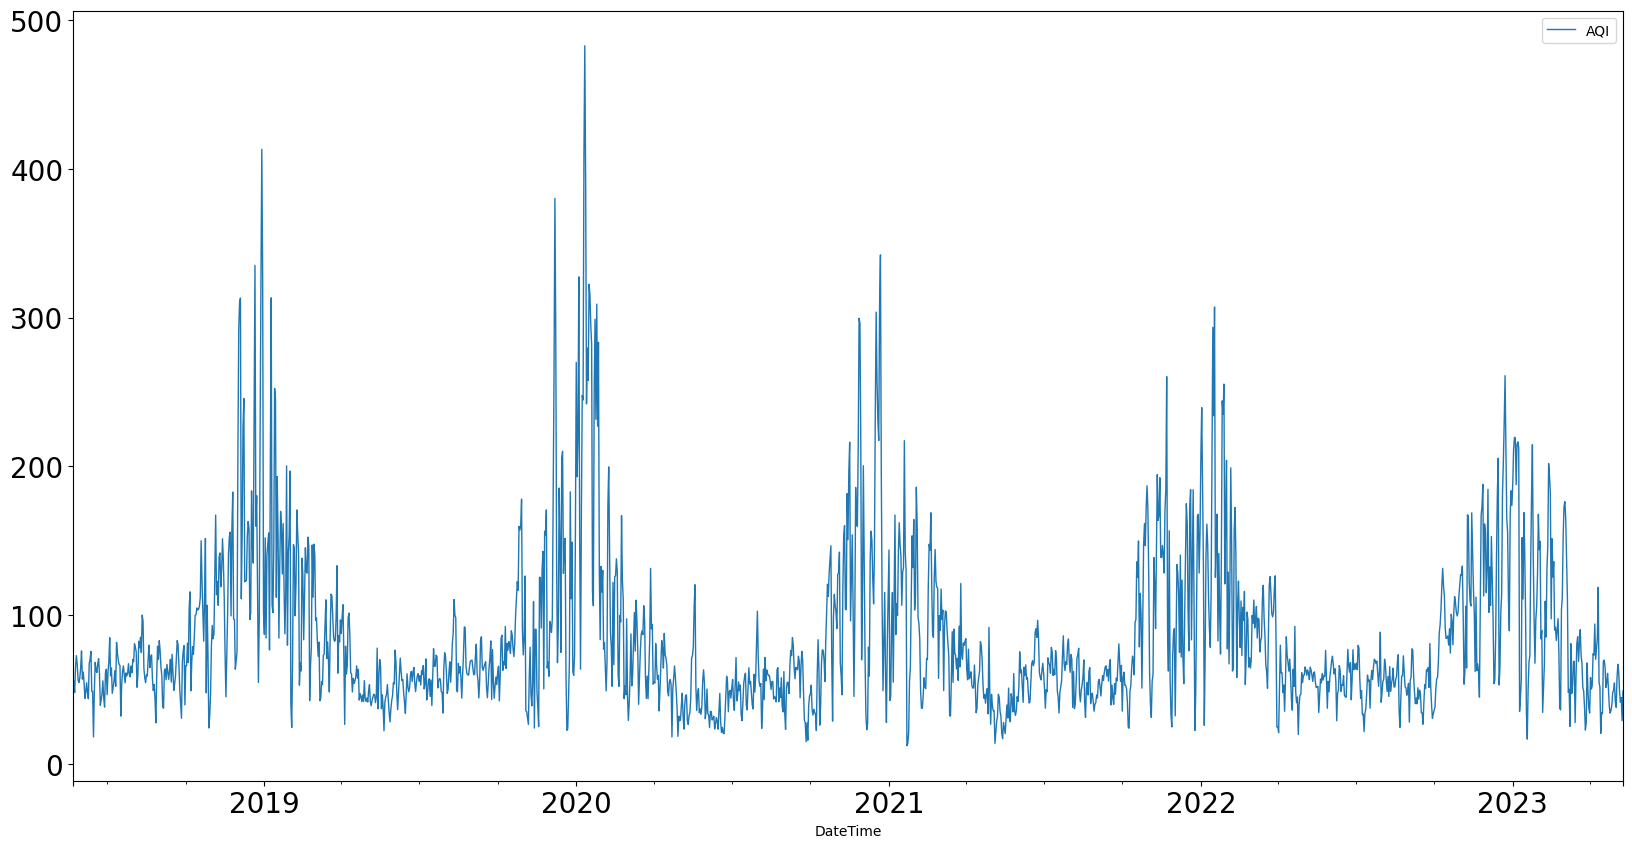

In [4]:
import matplotlib.pyplot as plt

# plot AQI
df_aqi_daily.plot(x='DateTime', y='AQI', figsize=(20,10), linewidth=1, fontsize=20)

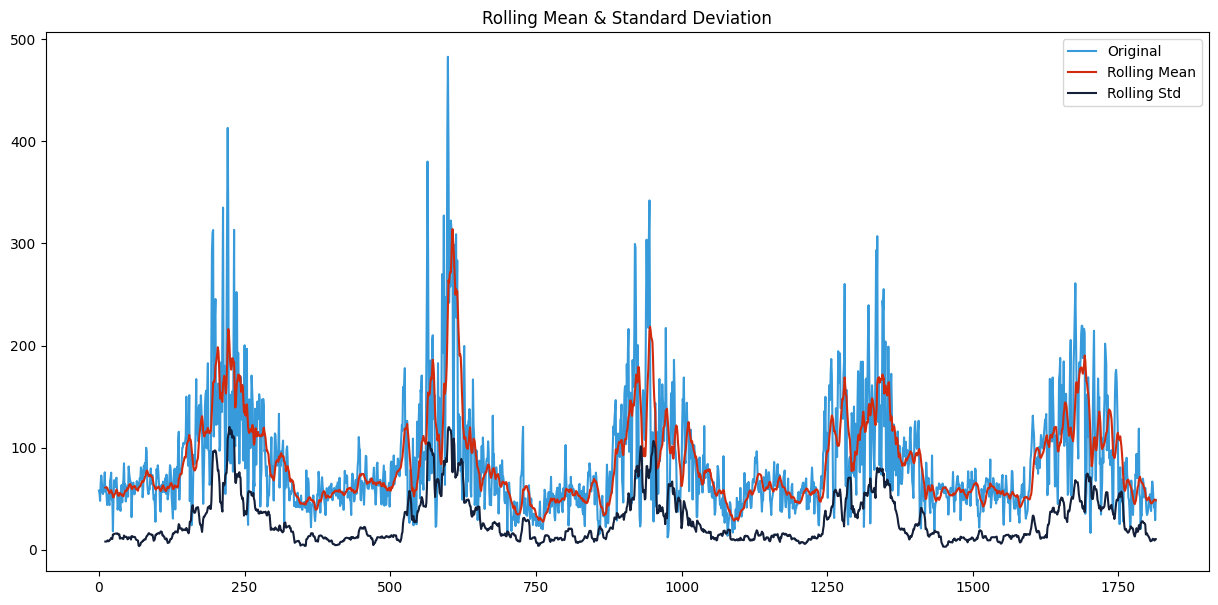

In [5]:
rolling_avg = df_aqi_daily["AQI"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolling_std = df_aqi_daily["AQI"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_aqi_daily["AQI"], color='#379BDB', label='Original')
plt.plot(rolling_avg, color='#D22A0D', label='Rolling Mean')
plt.plot(rolling_std, color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

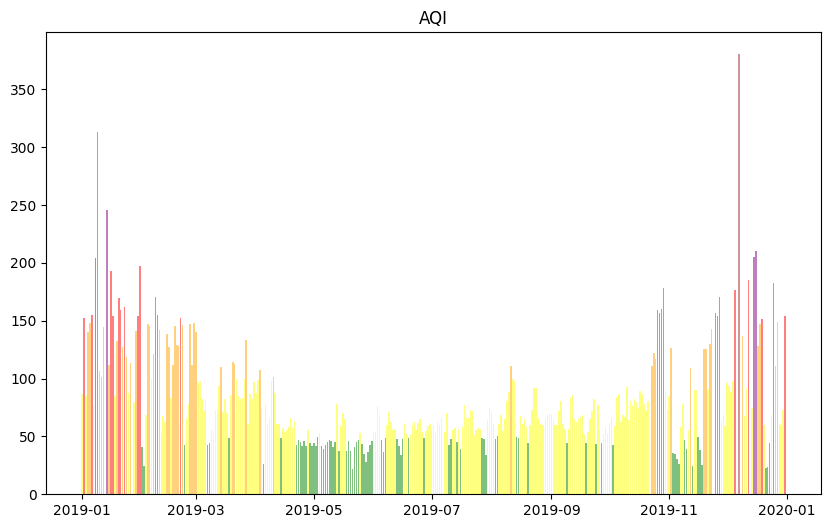

In [5]:
def plot_colored(df, start_date, end_date, label, categories):
    time_period = pd.date_range(start_date, end_date, freq='D')
    df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

    plt.figure(figsize=(10,6))

    for category in categories:
        color, start, end = category
        # plt.plot(df.loc[mask, label], color=color)
        # plt.hist(df.loc[(df[label] >= start) & (df[label] <= end), label], bins=20, color=color, alpha=0.5)
        plt.bar(df.loc[(df[label] >= start) & (df[label] <= end), "DateTime"], df.loc[(df[label] >= start) & (df[label] <= end), label], color=color, alpha=0.5)
        
    plt.title(label)
    plt.show()

categories = [('green', 0, 50), ('yellow', 51, 100), ('orange', 101, 150), ('red', 151, 200), ('purple', 201, 250), ('brown', 300, df_aqi_daily['AQI'].max())]
plot_colored(df_aqi_daily, '2019-01-01', '2019-12-31', 'AQI', categories)

In [4]:
def train_test_split(df, date):
    df = df.copy()
    train_data = df[df['DateTime'] < date].copy()
    test_data = df[df['DateTime'] >= date].copy()
    # df.DateTime = df.DateTime.dt.strftime('%d/%m/%Y %H:%M')
    return train_data, test_data

def train_test_split_from_to(df, start_date, end_date, slice_date):
    df = df.copy()
    train_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < slice_date)].copy()
    test_data = df[(df['DateTime'] >= slice_date) & (df['DateTime'] <= end_date)].copy()
    return train_data, test_data

def plot_train_test_data(train_data, test_data, date_column, label):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data')
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data')
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(label + ' Train and Test Data')
    plt.legend()
    plt.show()

In [5]:
# test dataset 31 days before the end of the dataset (it includes 0 to 30)
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=30)
train_data_aqi, test_data_aqi = train_test_split(df_aqi_daily, date)

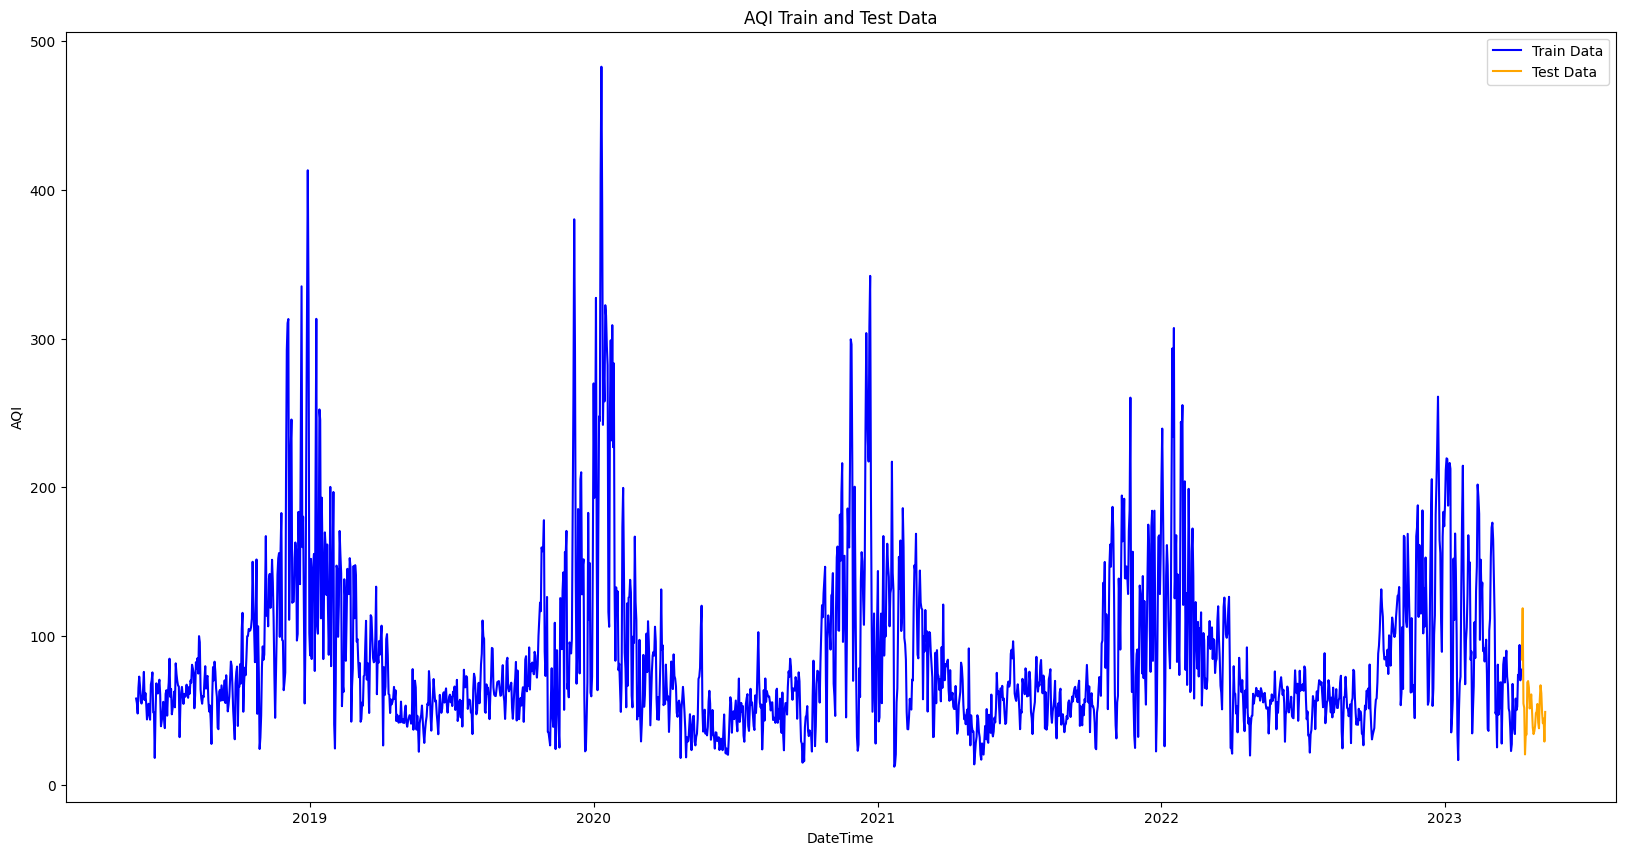

In [ ]:
plot_train_test_data(train_data_aqi, test_data_aqi, 'DateTime', 'AQI')


# FB Prophet

In [21]:
# %pip install prophet
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

def train_prophet(train_data):
    model = Prophet()
    model.fit(train_data)
    return model

def predict_prophet(model, test_data):
    forecast = model.predict(test_data)
    return forecast

def calculate_metrics(test, forecast, true_label='y', predicted_label='yhat'):
    mae = mean_absolute_error(test[true_label], forecast[predicted_label])
    rmse = sqrt(mae)
    r2 = r2_score(test[true_label], forecast[predicted_label])
    return rmse, mae, r2

def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(10,6))
    plt.boxplot(error)
    plt.show()

c:\Users\Vahidin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_data_aqi.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)
test_data_aqi.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)

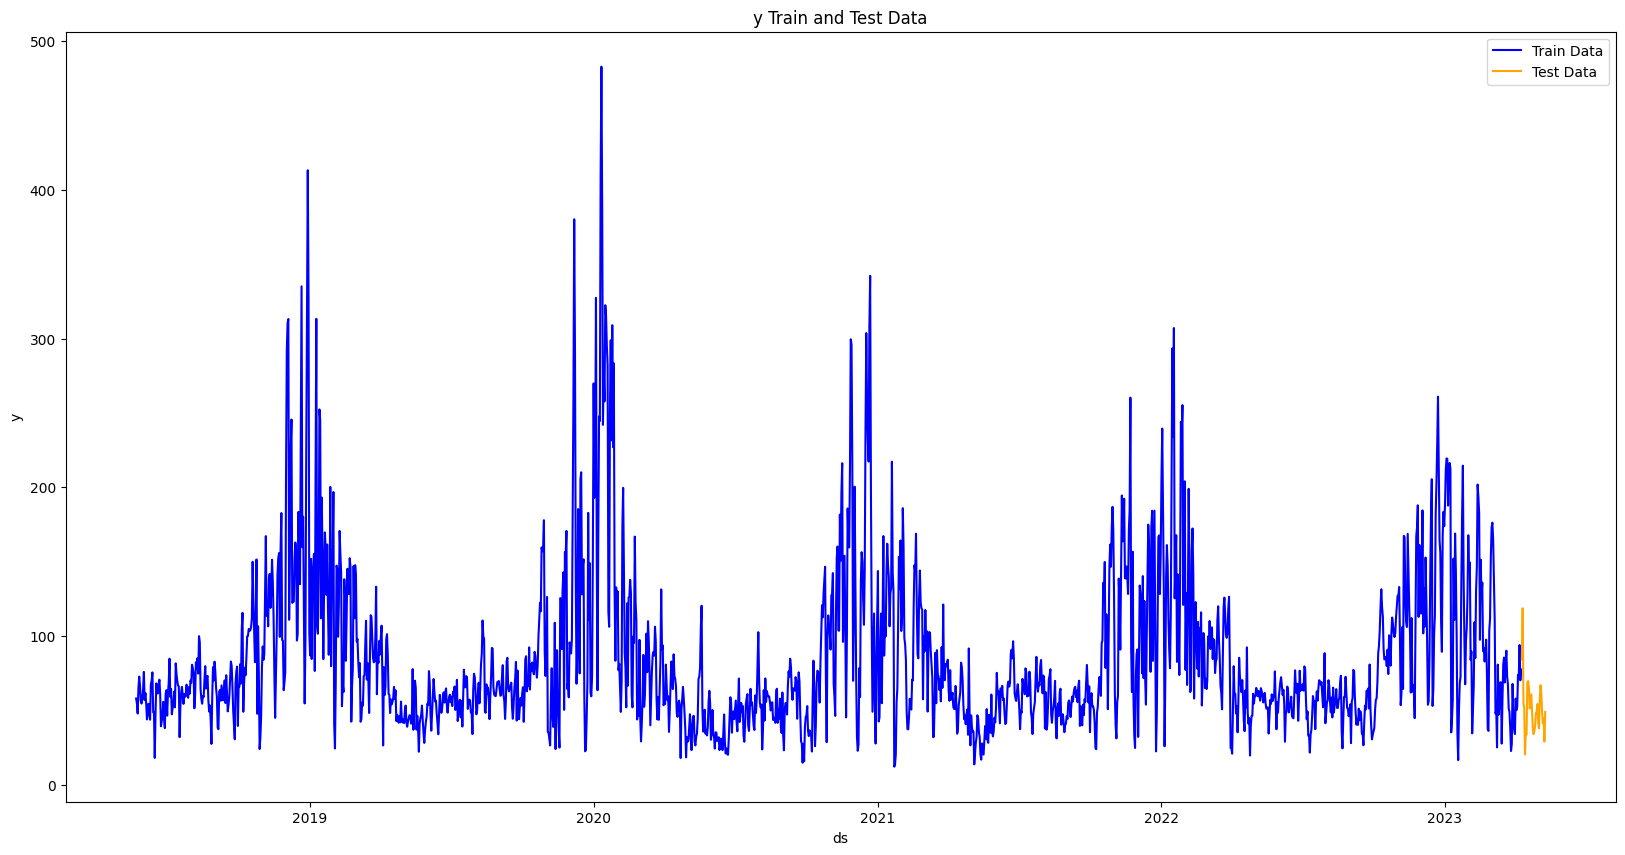

In [ ]:
# check if is accidentally changed
plot_train_test_data(train_data_aqi, test_data_aqi, 'ds', 'y')

In [ ]:
model_aqi = train_prophet(train_data_aqi)
forecast_aqi = predict_prophet(model_aqi, test_data_aqi)
rmse, mae, r2 = calculate_metrics(test_data_aqi, forecast_aqi)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)
# Results: RMSE: 3.552, MAE: 12.613, R2: 0.066. Great RMSE and MAE, but bad R2

20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 3.551
MAE: 12.610
R2: 0.067


In [ ]:
def plot_forecast(test, forecast, date_col='ds', true_label='y', predicted_label='yhat'):
    plt.figure(figsize=(10,6))
    plt.plot(test[date_col], test[true_label], label='Actual')
    plt.plot(test[date_col], forecast[predicted_label], label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(true_label)
    plt.title('Actual vs Predicted ' + true_label)
    plt.show()


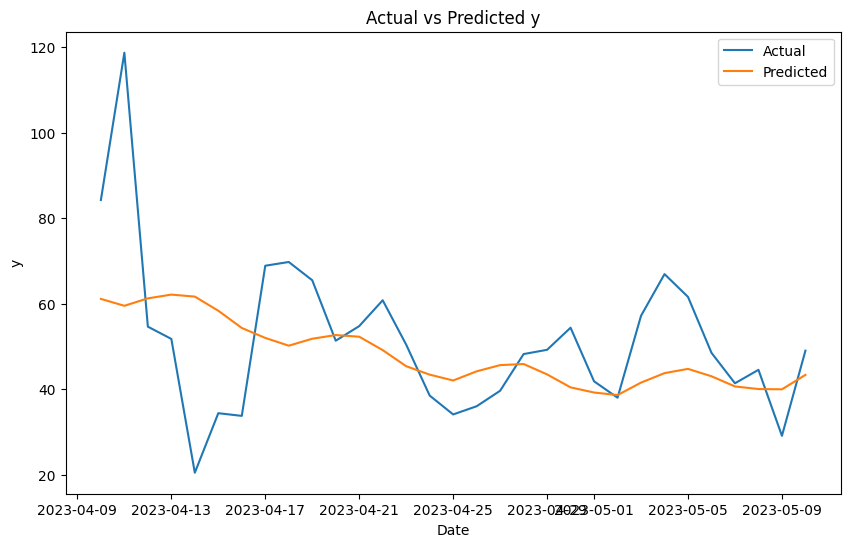

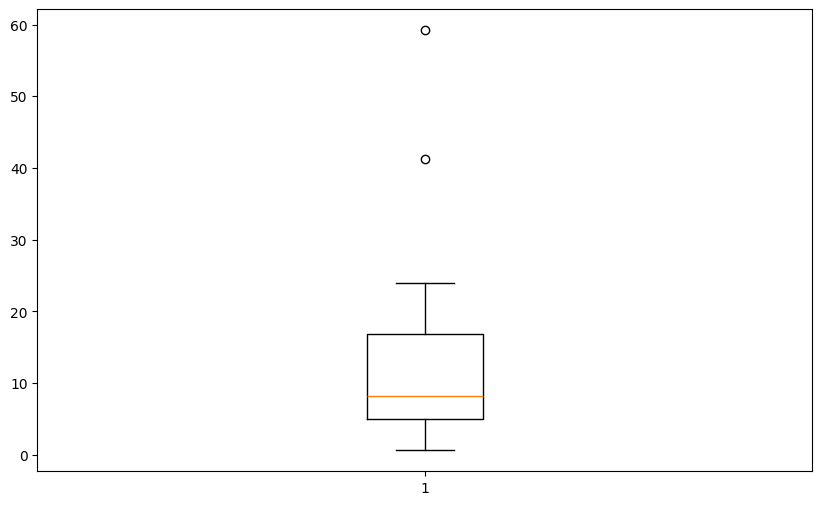

In [ ]:
plot_forecast(test_data_aqi, forecast_aqi)
plot_boxplot(forecast_aqi['yhat'].values.reshape(-1,1), test_data_aqi['y'].values.reshape(-1,1))

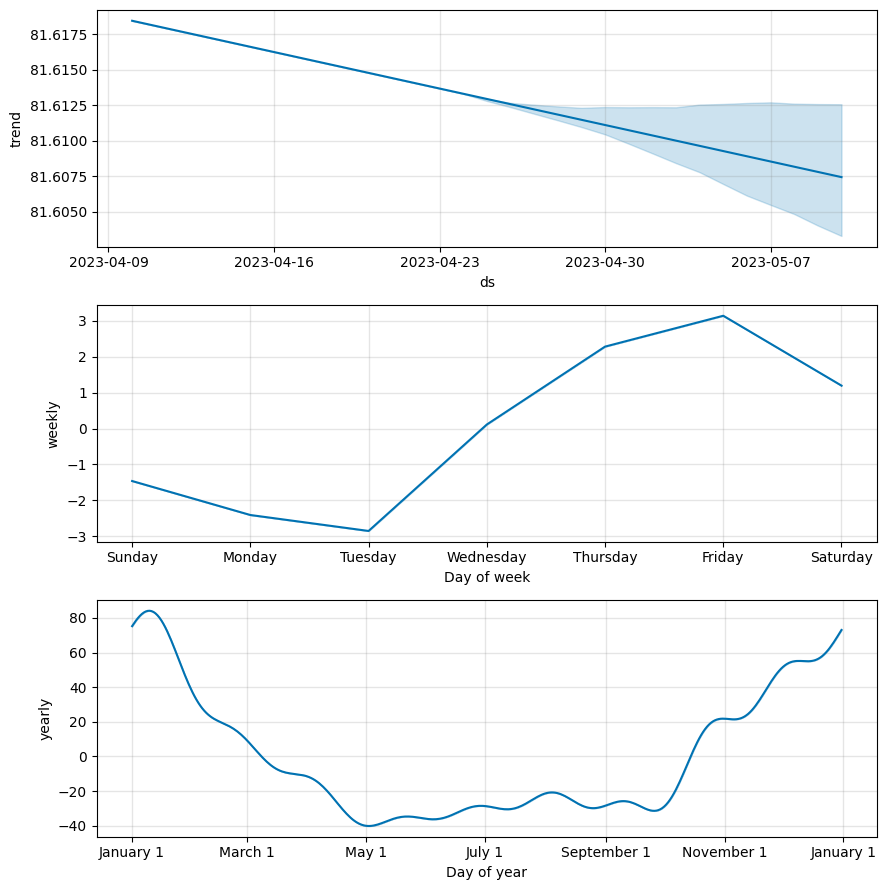

In [ ]:
# Visualizing the components of the forecast, such as the trend, yearly seasonality, and weekly seasonality. This can be done using the 'plot_components' method of the Prophet model

model_aqi.plot_components(forecast_aqi)
plt.show()

# LSTM

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# test dataset 31 days before the end of the dataset (it includes 0 to 30)
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=30)
train_data_aqi, test_data_aqi = train_test_split(df_aqi_daily, date)
train_data = train_data_aqi.set_index('DateTime')
test_data = test_data_aqi.set_index('DateTime')

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [33]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    # plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_dataset(data, look_back=1):
    """
    Create LSTM dataset by splitting the input data into input sequences (X) and corresponding output values (Y).

    Parameters:
    - data: numpy array, input data.
    - look_back: int, number of previous time steps to use as input variables to predict the next time period (default is 1).

    Returns:
    - X: numpy array, input sequences.
    - Y: numpy array, corresponding output values.
    """
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)

# # Define model
# def build_model(train_shape, look_back):
#     model = Sequential()
#     model.add(LSTM(100, return_sequences=True, input_shape=(train_shape, look_back)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     # model.add(LSTM(100, input_shape=(train_shape, look_back), return_sequences=True))
#     # model.add(Dropout(0.2))
#     # model.add(LSTM(50, return_sequences=True))
#     # model.add(Dropout(0.2))
#     # model.add(LSTM(50, return_sequences=False))
#     # model.add(Dense(25))
#     # model.add(Dense(1))
#     # model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#     return model

def build_model(train_shape, look_back, params):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(train_shape, look_back)))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=False))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(Dense(1))
	model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

def train_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    # x_val = x_train[-50:]
    # y_val = y_train[-50:]
    # x_train = x_train[:-50]
    # y_train = y_train[:-50]
    # history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stop])
    history = model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=1, callbacks=[early_stop])
    return history

In [34]:
# Prepare input and output for LSTM model
look_back = 5
x_train, y_train = create_dataset(train_data, look_back)
# x_test, y_test = create_dataset(test_data, look_back)

In [35]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

Epoch 1/10
1778/1778 [==============================] - 22s 7ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - mean_absolute_error: 0.0600
Epoch 2/10
1778/1778 [==============================] - 12s 7ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - mean_absolute_error: 0.0522
Epoch 3/10
1778/1778 [==============================] - 11s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - mean_absolute_error: 0.0515
Epoch 4/10
1778/1778 [==============================] - 11s 6ms/step - loss: 0.0059 - root_mean_squared_error: 0.0770 - mean_absolute_error: 0.0522
Epoch 5/10
1778/1778 [==============================] - 12s 7ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - mean_absolute_error: 0.0517
Epoch 6/10
1778/1778 [==============================] - 12s 7ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - mean_absolute_error: 0.0506
Epoch 7/10
1778/1778 [==============================] - 12s 7ms/step - loss: 0.0056 - root_mean_squared_error: 0

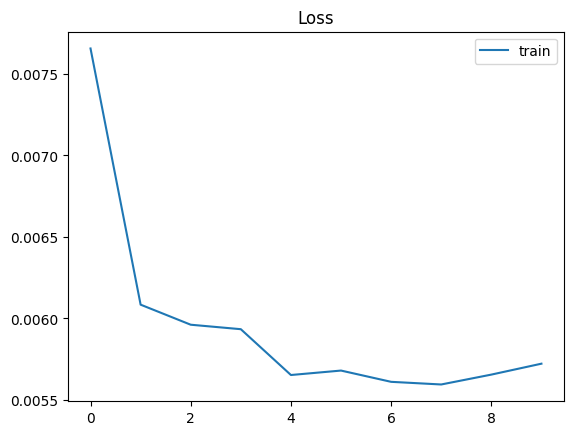

In [36]:
# Training the model
# model = build_model(x_train.shape[1], look_back)
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
    "dropout": 0.2,
	"lstm_units": 100,
}
model = build_model(x_train.shape[1], look_back, params)
history = train_model(model, x_train, y_train)
plot_loss(history)

In [37]:
# Using sequential predictions
# making test set: x_test[0] = x_train[-5:]; x_test[1] = x_train[-4:],x_test[0]; x_test[2] = x_train[-3:],x_test[0],x_test[1] and so on
x_test = train_data[-look_back:]
y_test = test_data
testPredict = []

for i in range(0, len(test_data)):
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (1, 1, look_back))
    y_pred = model.predict(x_test)
    # append y_pred value to testPredict
    testPredict.append(y_pred[0][0])
    # push the predictions to the end of the test set so it pushes out first value 
    x_test = np.append(x_test, y_pred)
    x_test = x_test[1:]

1/1 [==============================] - 0s 43ms/step


In [17]:
# make predictions
trainPredict = model.predict(x_train)
# testPredict = model.predict(x_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

56/56 [==============================] - 0s 4ms/step


In [38]:
testPredict = [testPredict]
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

In [39]:
# calculate root mean squared error
mae = mean_squared_error(y_test[0], testPredict[:,0])
rmse = np.sqrt(mae)
r2 = r2_score(y_test, testPredict.T)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

# Results for different look_back:
# look_back=3
# RMSE: 12.97770941270771
# MAE: 168.4209416006823
# R2 Score: -0.052660997878037685


# look_back=5
# RMSE: 10.648520567528376
# MAE: 113.39099027707483
# R2 Score: 0.19789332665116666
# With sequential predictions
# RMSE: 6.185622330134109
# MAE: 38.261923611053724
# R2 Score: -2.504621096071074

# look_back=10
# RMSE: 9.68743352002617
# MAE: 93.84636820492665
# R2 Score: 0.03021601946660468

RMSE: 2.672839186464742
MAE: 7.144069316701504
R2 Score: -12.221889958760821


In [ ]:
# # shift train predictions for plotting
# trainPredictPlot = np.empty_like(df_aqi_daily)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(df_aqi_daily)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_aqi_daily)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(df_aqi_daily.AQI, label='Actuval AQI', color='blue')
# plt.plot(trainPredictPlot, label='Train Prediction', color='orange')
# plt.plot(testPredictPlot, label='Test Prediction', color='green')
# plt.show()


# plot_boxplot(testPredict.flatten(), y_test[0])

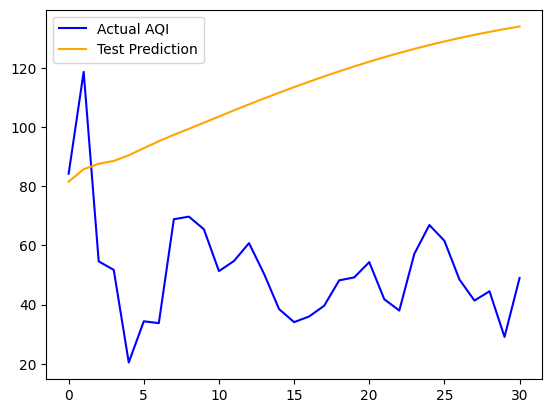

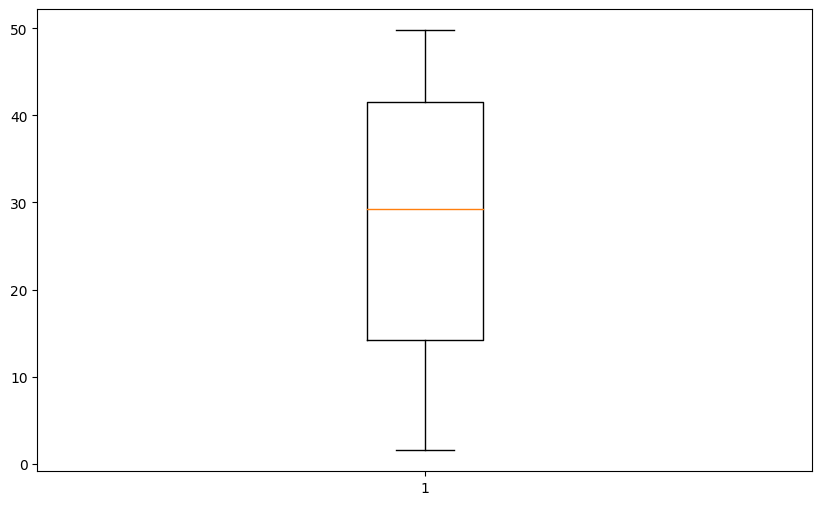

In [40]:
# plot y_test and testPredict
plt.plot(y_test, label='Actual AQI', color='blue')
plt.plot(testPredict.T, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict.T, y_test[0])

# ARIMA

c:\Users\Vahidin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


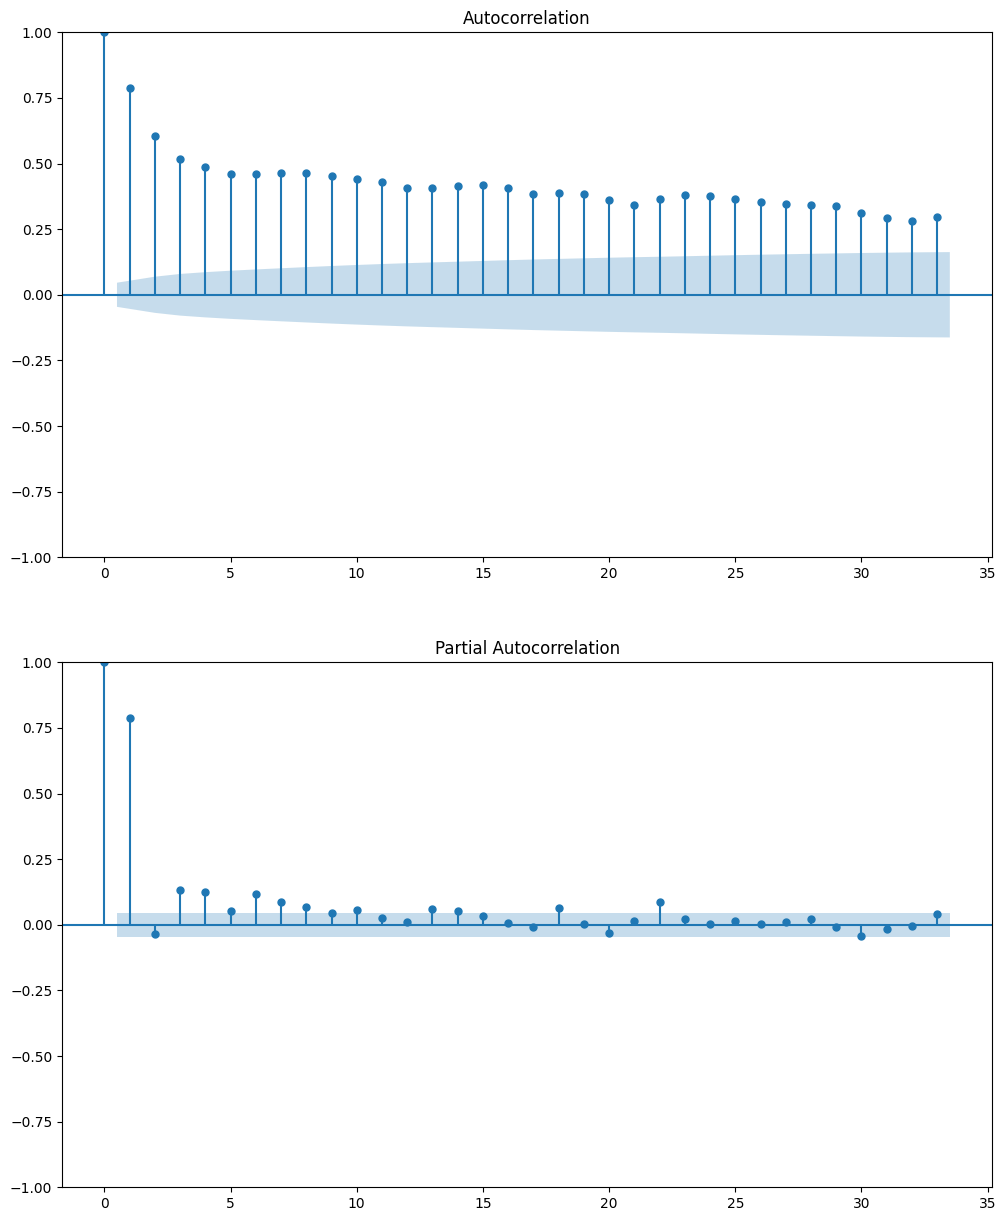

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(df_column, lag=None):
    """
    Plots ACF and PACF to determine the order of the non-seasonal components if lag is not specified
    else plots seasonal ACF and PACF to determine the order of the seasonal components.
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 15))
    plot_acf(df_column, lags=lag, ax=ax[0])
    plot_pacf(df_column, lags=lag, ax=ax[1])
    plt.show()

# plotting before differencing
plot_acf_pacf(df_aqi_daily['AQI'])

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def calculate_ads_kpss(df_column):
    """
    Calculates the p-values for the Augmented Dickey-Fuller test and Kwiatkowski-Phillips-Schmidt-Shin test.
    """
    adsResult = adfuller(df_column, autolag='AIC')
    adsPvalue = adsResult[1] # p value smaller than 0.05 means that the series is stationary
    kpssResult = kpss(df_column, regression="c",nlags='auto')
    kpssPvalue = kpssResult[1] # p value grated than 0.05 means that the series is stationary
    return adsPvalue, kpssPvalue

adsPvalue, kpssPvalue = calculate_ads_kpss(df_aqi_daily['AQI'])
print("KPSS p value:",kpssPvalue)
print("ADS p value:",adsPvalue)
if kpssPvalue > 0.05 and adsPvalue < 0.05:
    print("Time series is strictly stationary")
# Time series is not stationary, even though this test says it is?

c:\Users\Vahidin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


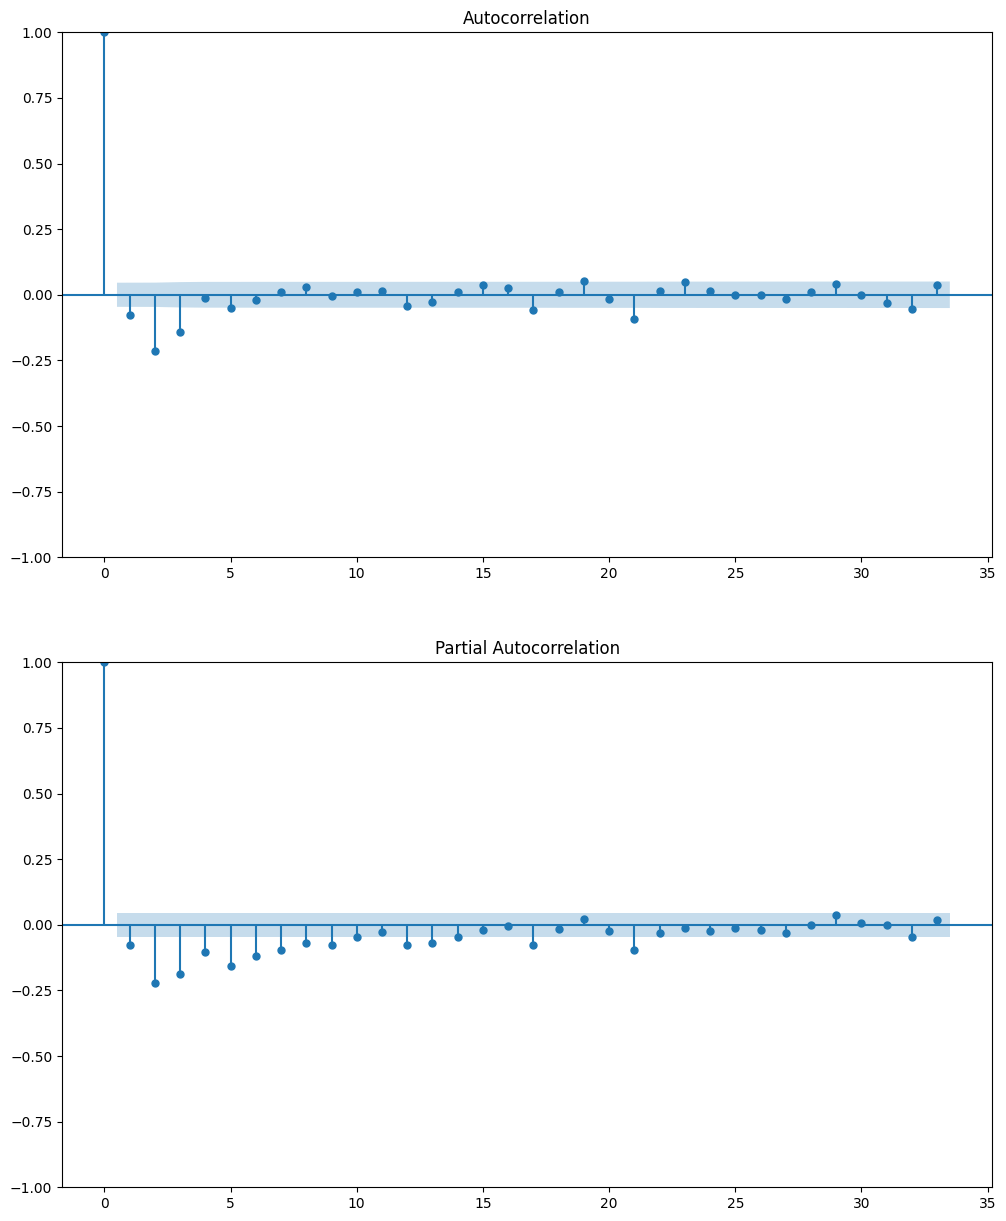

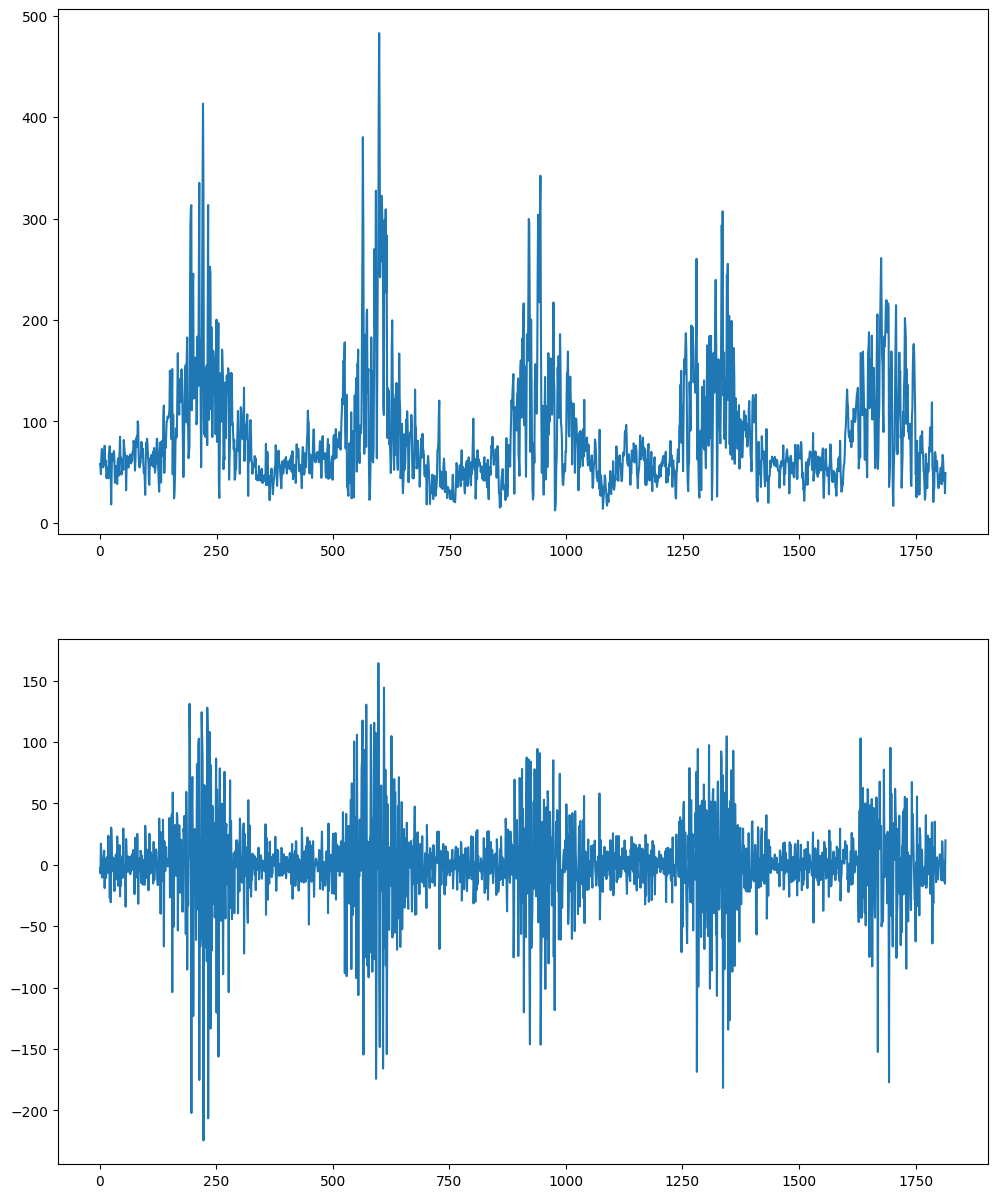

In [ ]:
# difference the time series to remove trend
df_aqi_daily_diff = df_aqi_daily['AQI'].diff().dropna()
# plotting after differencing
plot_acf_pacf(df_aqi_daily_diff)
# df_aqi_daily_diff is still not stationary
# plot df_aqi_daily and df_aqi_daily_diff on two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 15))
ax[0].plot(df_aqi_daily['AQI'])
ax[1].plot(df_aqi_daily_diff)
plt.show()

c:\Users\Vahidin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


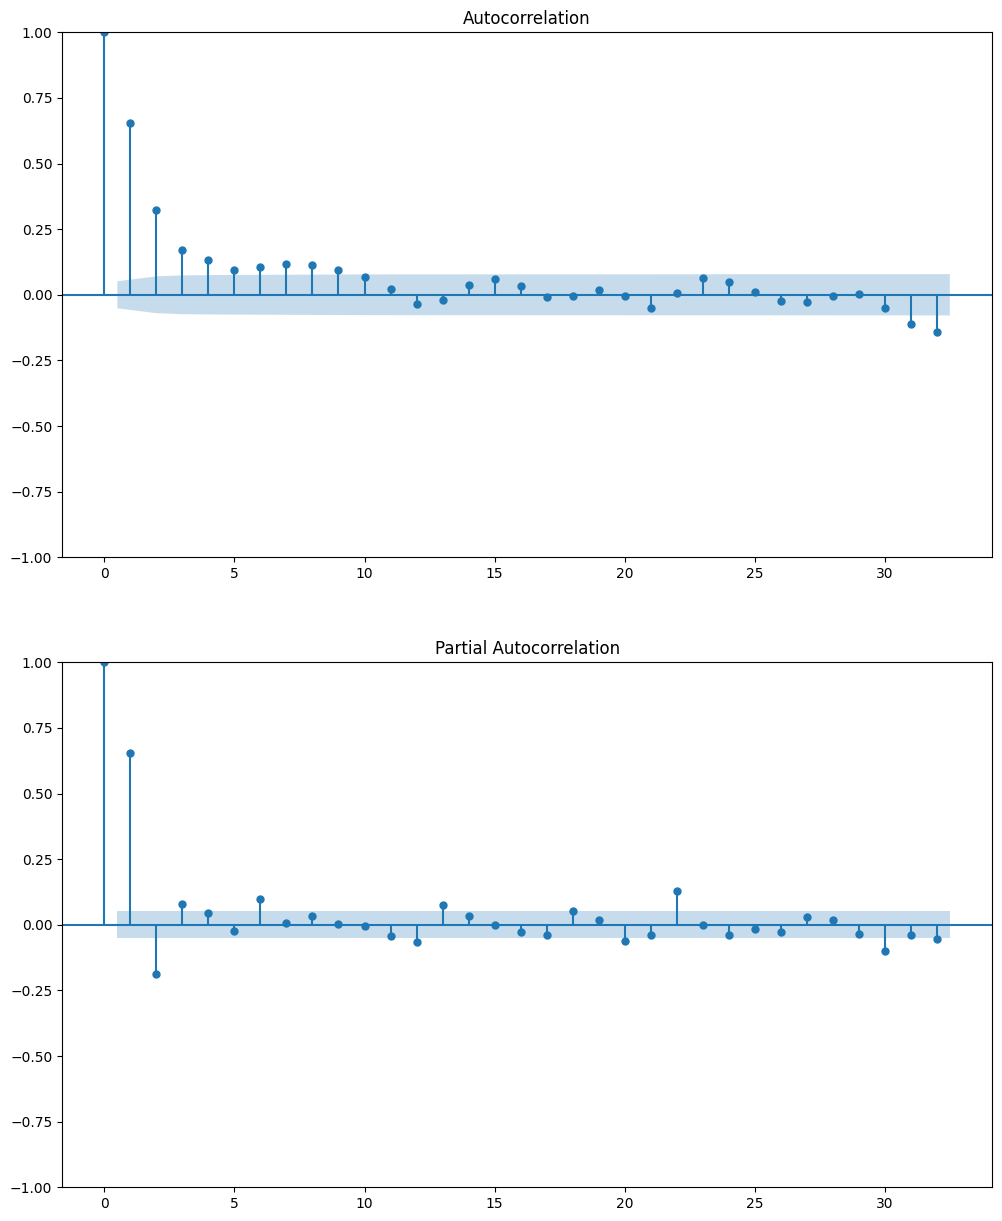

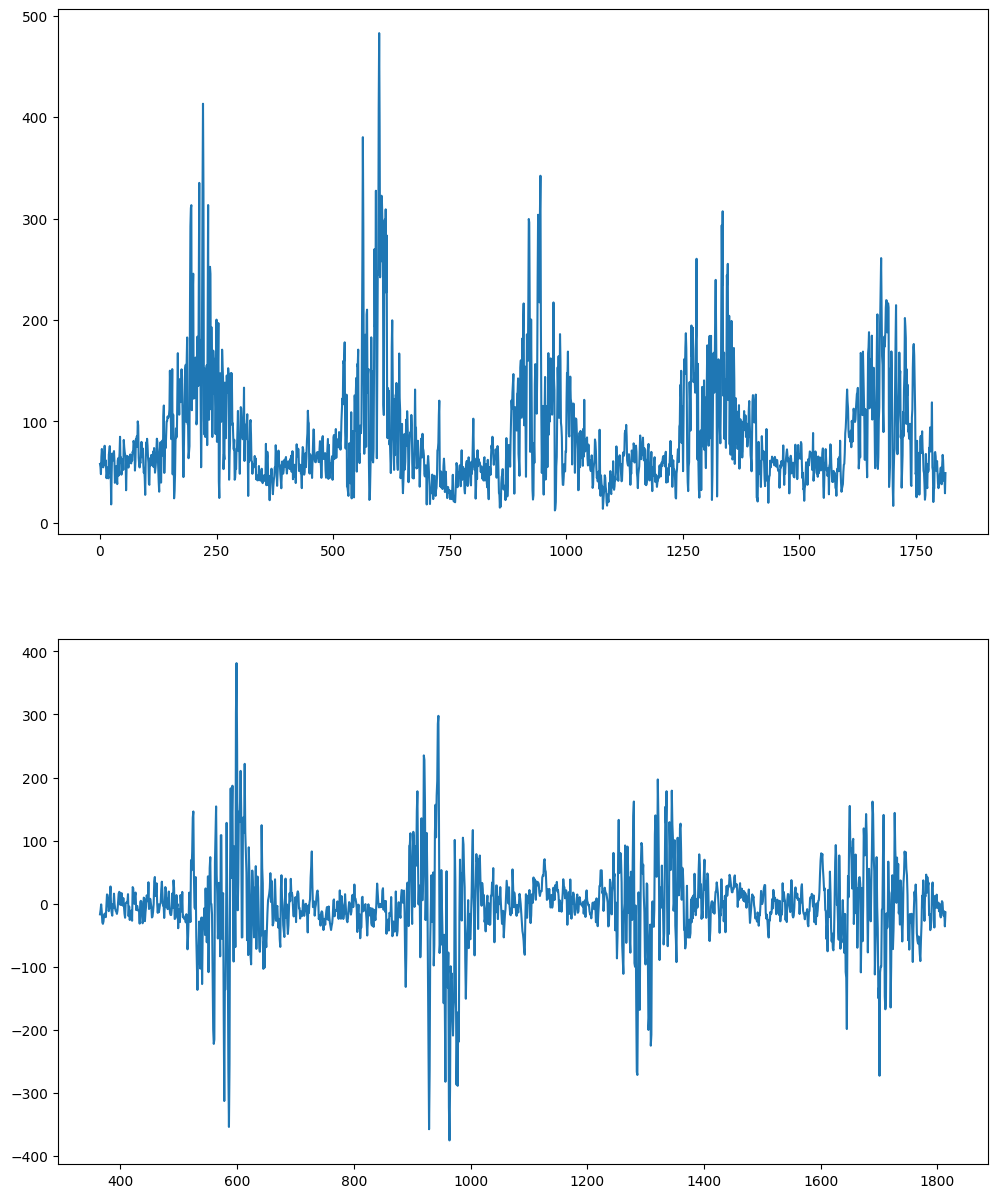

In [ ]:
# Seasonal Differencing
df_aqi_daily_diff = df_aqi_daily['AQI'].diff(periods=365).dropna()
# plotting after differencing
plot_acf_pacf(df_aqi_daily_diff)
# df_aqi_daily_diff is still not stationary
# plot df_aqi_daily and df_aqi_daily_diff on two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 15))
ax[0].plot(df_aqi_daily['AQI'])
ax[1].plot(df_aqi_daily_diff)
plt.show()

c:\Users\Vahidin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


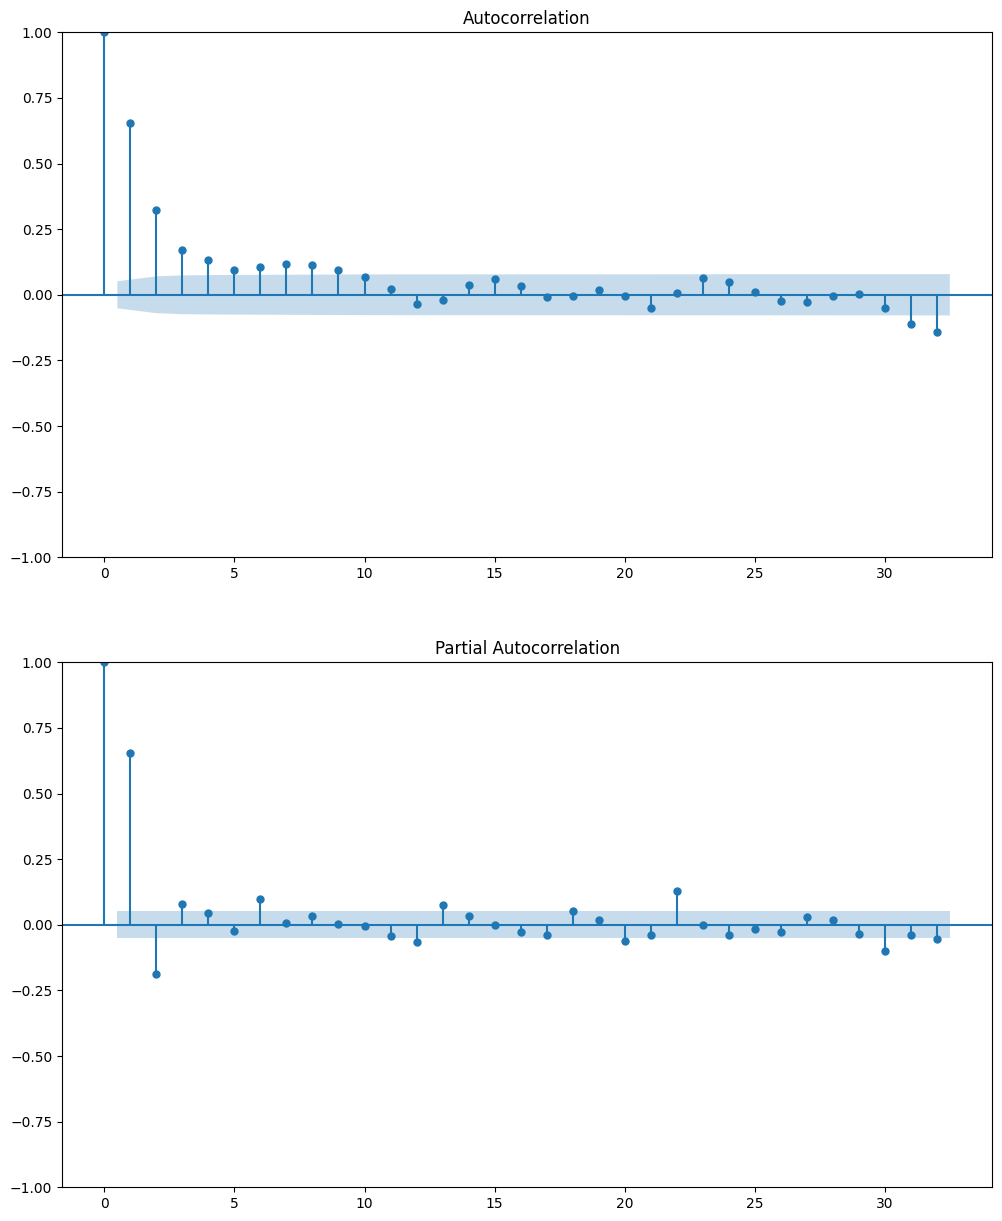

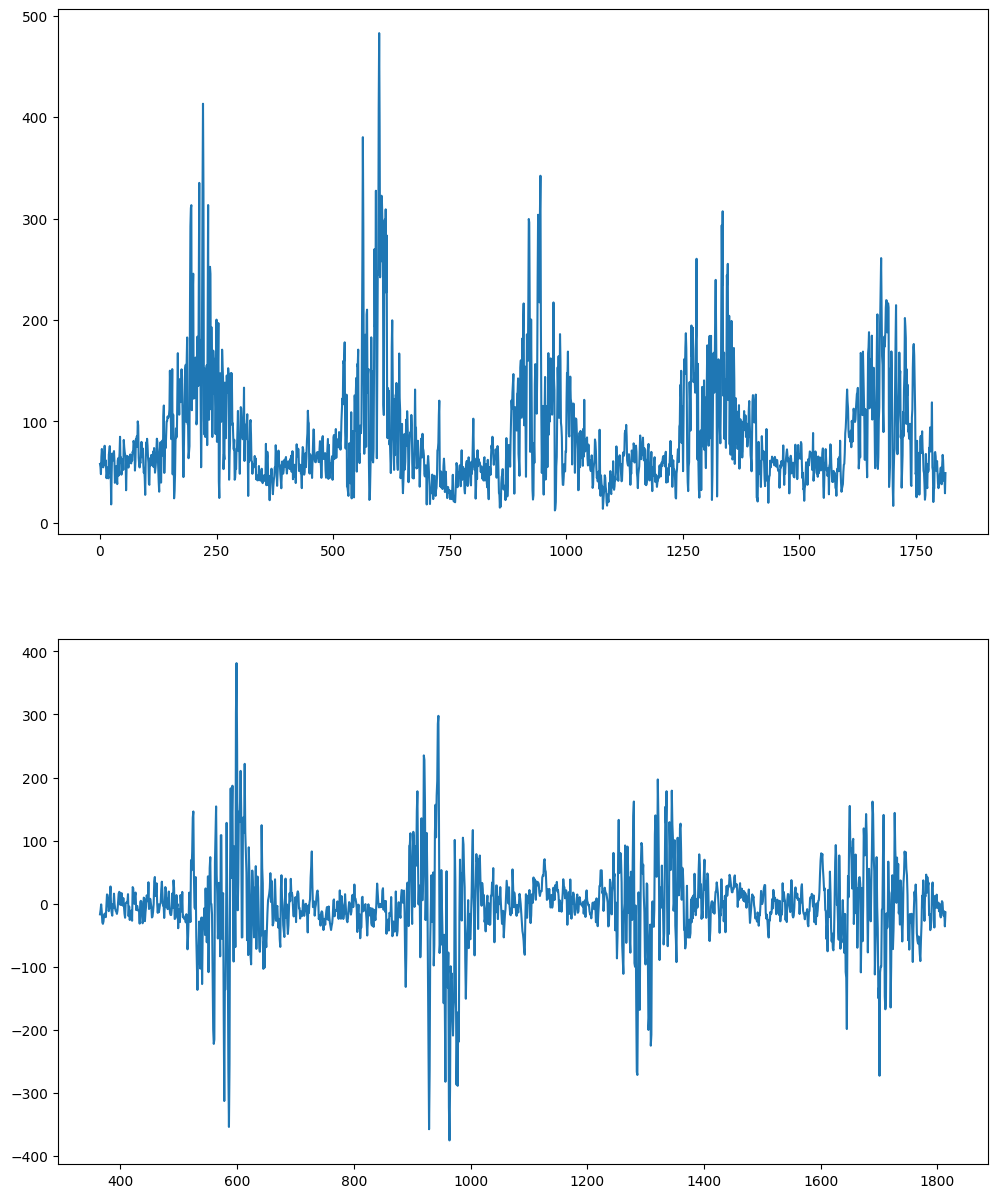

In [ ]:
import numpy as np

# do log transformation to remove trend
df_aqi_daily_log = np.log(df_aqi_daily['AQI'])
plot_acf_pacf(df_aqi_daily_diff)
fig, ax = plt.subplots(2, 1, figsize=(12, 15))
ax[0].plot(df_aqi_daily['AQI'])
ax[1].plot(df_aqi_daily_diff)
plt.show()
# still not stationary??

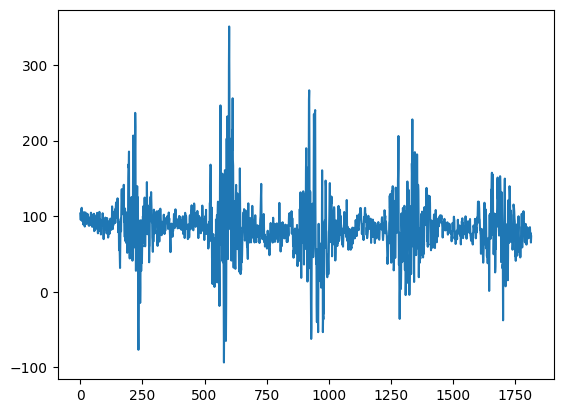

In [ ]:
# removing seasonality
from statsmodels.tsa.seasonal import STL

# Decompose the time series
# STL - Seasonal and Trend decomposition using Loess: seasonal, trend, and residuals components
stl = STL(df_aqi_daily['AQI'], period=365, seasonal=365)
result = stl.fit()

# Plot the decomposition
# fig = result.plot()

# Get the seasonal component
seasonal = result.seasonal

# Remove the seasonal component
df_aqi_daily_deseasonalized = df_aqi_daily['AQI'] - seasonal

# Plot the deseasonalized time series
df_aqi_daily_deseasonalized.plot()
plt.show()

In [ ]:
import pmdarima as pm


# find best parameters

model = pm.auto_arima(train_data_aqi.AQI, d=None, stationary=False, seasonal=False, trace=True, stepwise=True)


# model = pm.auto_arima(y_train, start_p=0, start_q=0,
#                       max_p=4, max_q=10,
#                       m=1,
#                       d=None,
#                       seasonal=False,
#                       start_P=0,
#                       D=0,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True,
#                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=17553.443, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21555.966, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=17805.868, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19902.212, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=17636.260, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=17809.382, Time=0.46 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=17552.638, Time=1.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=17550.654, Time=0.88 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=17734.501, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=17552.635, Time=1.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=17804.225, Time=0.19 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=17683.745, Time=0.34 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=17553.268, Time=2.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=17540.557, Time=2.73 sec
 ARIMA(2,0,1)(0,0,0

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Defining and fiting ARIMA model
model = ARIMA(train_data_aqi.AQI, order=(3, 0, 1))
model_fit = model.fit()
# print(model_fit.summary())

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# Prediction with ARIMA
y_pred = model_fit.forecast(31)

mae = mean_absolute_error(test_data_aqi.AQI, y_pred)
rmse = sqrt(mae)
r2 = r2_score(test_data_aqi.AQI, y_pred)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)


RMSE: 4.946
MAE: 24.466
R2: -1.313


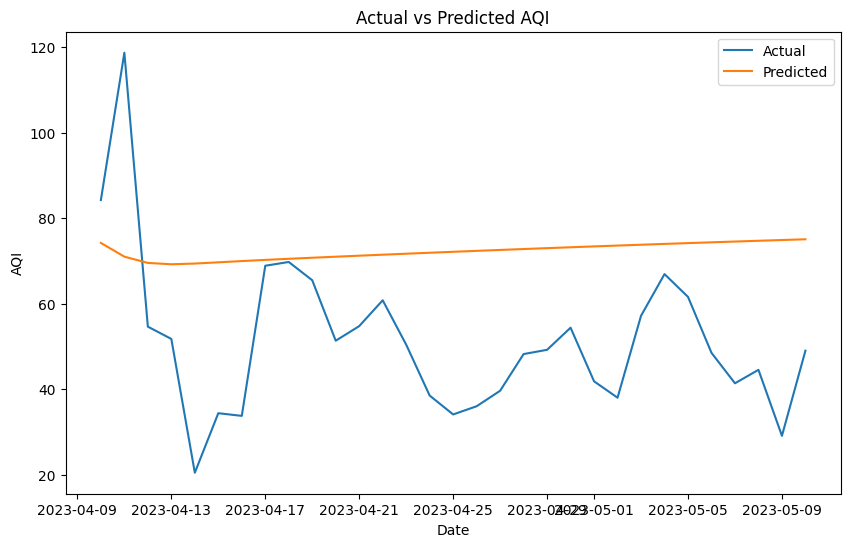

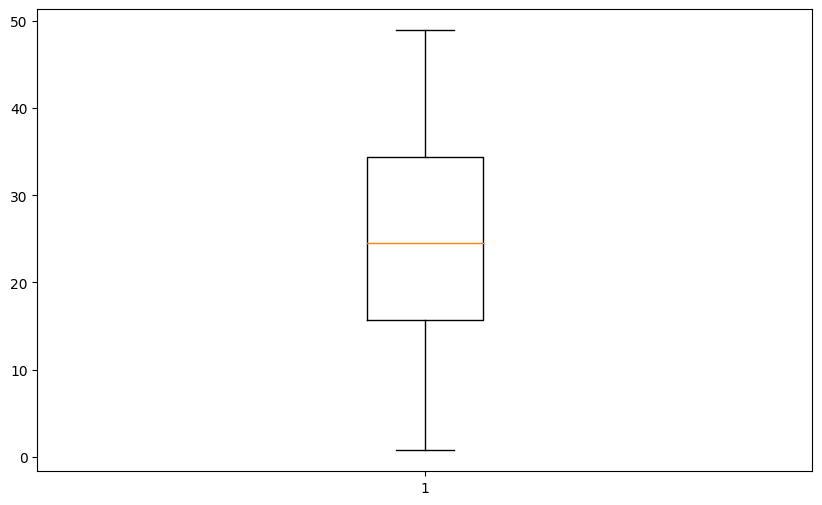

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_data_aqi.DateTime, test_data_aqi.AQI, label='Actual')
plt.plot(test_data_aqi.DateTime, y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI')
plt.show()

# plot boxplot of error
plot_boxplot(y_pred, test_data_aqi.AQI)

# SARIMA

In [ ]:
# %pip install pmdarima

In [ ]:
import pmdarima as pm

# find best parameters
# model = pm.auto_arima(train_data_aqi.AQI, d=None, m=365, stationary=False, seasonal=True, trace=True, suppress_warnings=True, stepwise=False, n_jobs=-1)

model = pm.auto_arima(train_data_aqi.AQI, seasonal=True, m=365, trace=True, stepwise=True)

#? takes too long to run

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit the SARIMA model
order = (3, 0, 1)
seasonal_order = (3, 0, 1, 365)
model = SARIMAX(train_data_aqi.AQI, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
model_fit.plot_diagnostics(figsize=(12,8))

In [ ]:
# make predictions
pred = model_fit.get_prediction(30)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

mae = mean_absolute_error(test_data_aqi.AQI, pred)
rmse = sqrt(mae)
r2 = r2_score(test_data_aqi.AQI, pred)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)


In [ ]:
# Plotting forecast
plt.figure(figsize=(10,6))
plt.plot(test_data_aqi.DateTime, test_data_aqi.AQI, label='Actual')
plt.plot(test_data_aqi.DateTime, pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI')
plt.show()

plot_boxplot(pred, test_data_aqi.AQI)

# Exponential smoothing

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing


model = ExponentialSmoothing(train_data_aqi.AQI)
fit1 = model.fit(use_brute=True)
pred1 = fit1.forecast(steps=31)

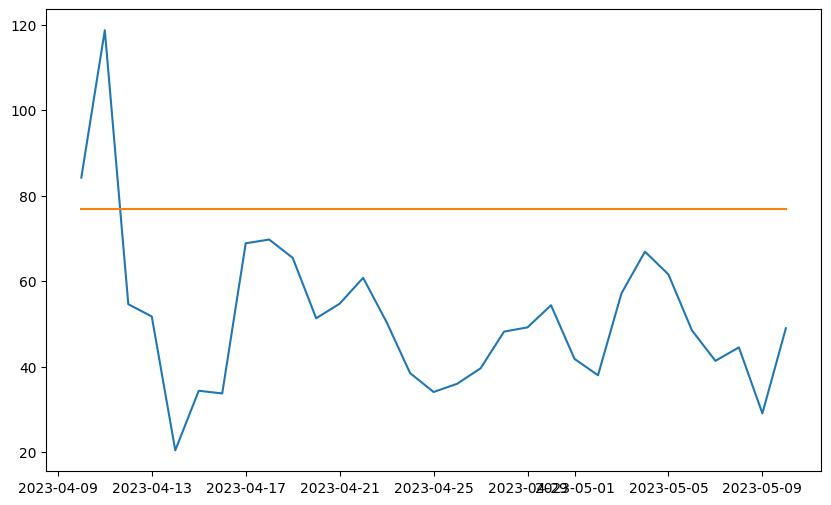

In [15]:
# plot test_data_aqi.AQI, pred1
plt.figure(figsize=(10,6))
plt.plot(test_data_aqi.DateTime, test_data_aqi.AQI, label='Actual')
plt.plot(test_data_aqi.DateTime, pred1, label='Predicted')
plt.show()